# Preprocessing Sentinel-2 Data for Segmentation of Crop types 

Hello and welcome to this guide. The first step of this guide will show you how to preprocess your data for semantic segmentation. Frist rember to download the data from Sentinel Hub or a simlar source before proceeding.

The first step is to load package needed for the modelling and preprocessing of data:

In [12]:
import os, glob, functools, json
from itertools import product
from pathlib import Path

import tifffile as tiff

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image

import rasterio
from rasterio import features, windows
import cv2

import geopandas as gpd

Having loaded the packages the next step is to load the data. In this case the mask data or annotated imagery is stored as a geojson file. This file can be opened and stored via the usage of the geopands package.

classes in labels geojson:  [9 1 8 2 3 5 6 7 4]
named classes in labels geojson:  ['Forage Crops' 'Wheat' 'Meadows' 'Rye' 'Barley' 'Corn' 'Oil Seeds'
 'Root Crops' 'Oats']
sorted classes in labels geojson:  [1 2 3 4 5 6 7 8 9]


<Axes: >

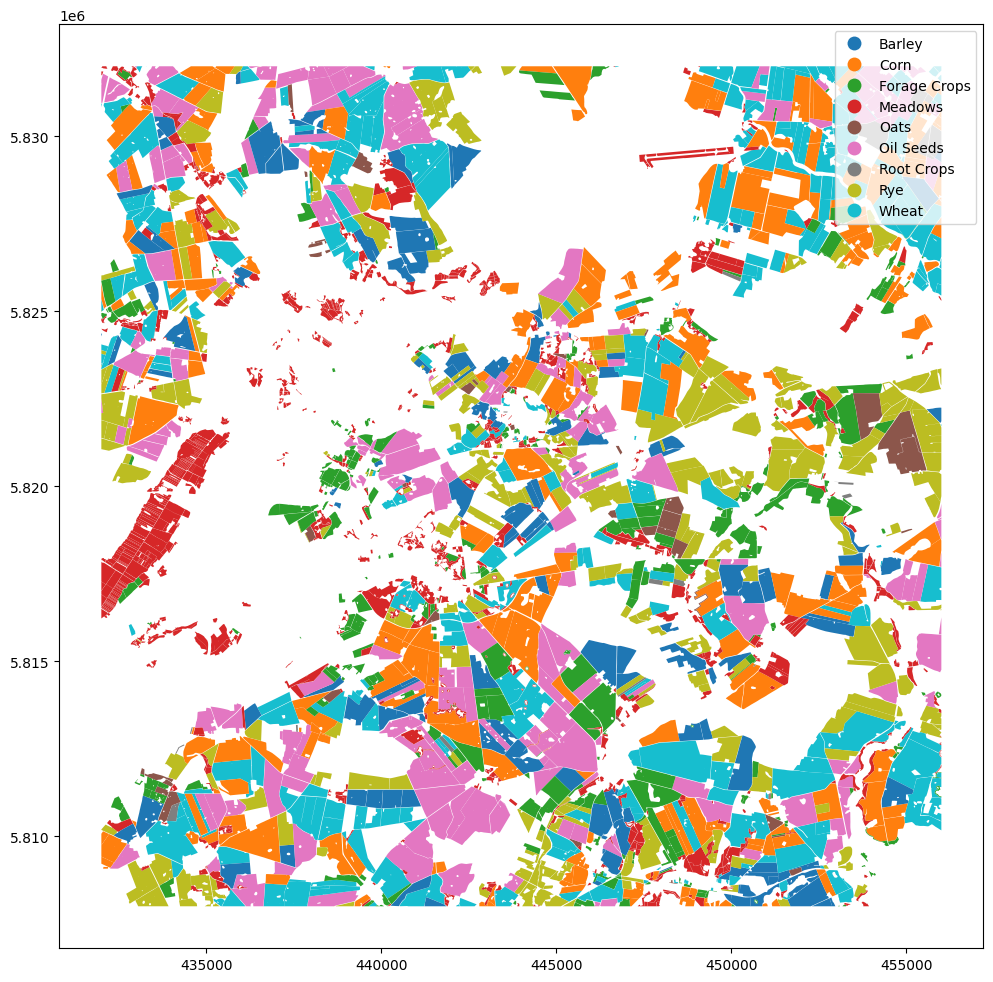

In [6]:
# labels for one year
labels_geo= gpd.read_file('/media/mabso/Data/downloads/demo_segmentation/training_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/labels.geojson')

# label from another year and tile
#labels_geo = gpd.read_file('/home/mabso/Desktop/statelite dataset/german crops/dlr_fusion_competition_germany_test_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/labels.geojson')

classes = labels_geo.crop_id.unique() # unique class
names_class=labels_geo.crop_name.unique() # acutal name of each class

print("classes in labels geojson: ", classes)
print("named classes in labels geojson: ", names_class)

classes.sort()
print("sorted classes in labels geojson: ", classes)

# plotting the labels using geopandas:
labels_geo.plot(column='crop_name', legend=True, aspect=1)



These pixel wise labels would serve as our ground truth for the segmentation task at hand. However, first we need to import and process the underlying imagery. First step is to find the trainig images to see if something is there

['/media/mabso/Data/downloads/demo_segmentation/training_data/2018-02-01/labels.tif', '/media/mabso/Data/downloads/demo_segmentation/training_data/2018-02-01/scl.tiff', '/media/mabso/Data/downloads/demo_segmentation/training_data/2018-02-01/sr.tiff', '/media/mabso/Data/downloads/demo_segmentation/training_data/2018-02-01/sr_byte_scaled.tif', '/media/mabso/Data/downloads/demo_segmentation/training_data/2018-02-01/stack.tif']


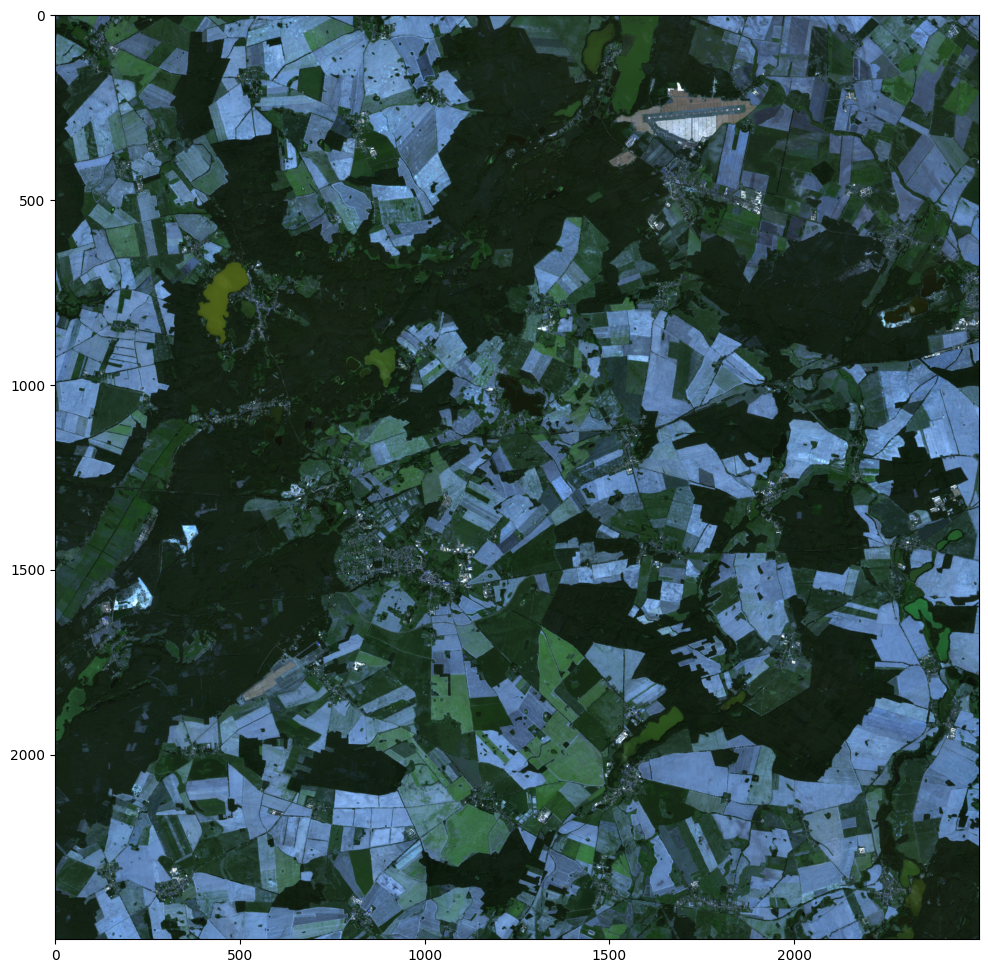

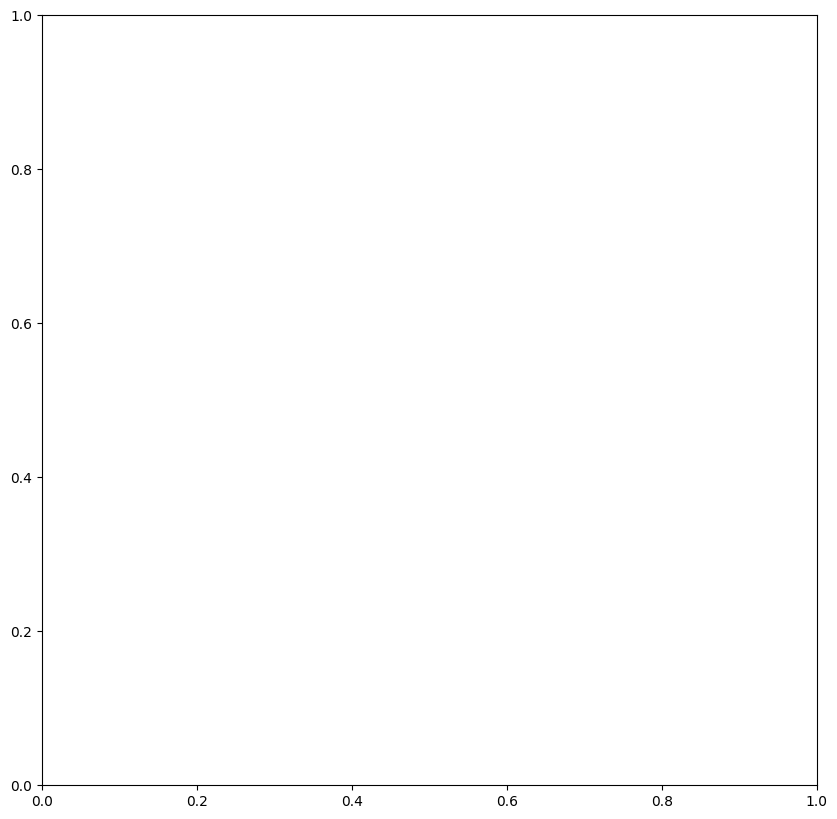

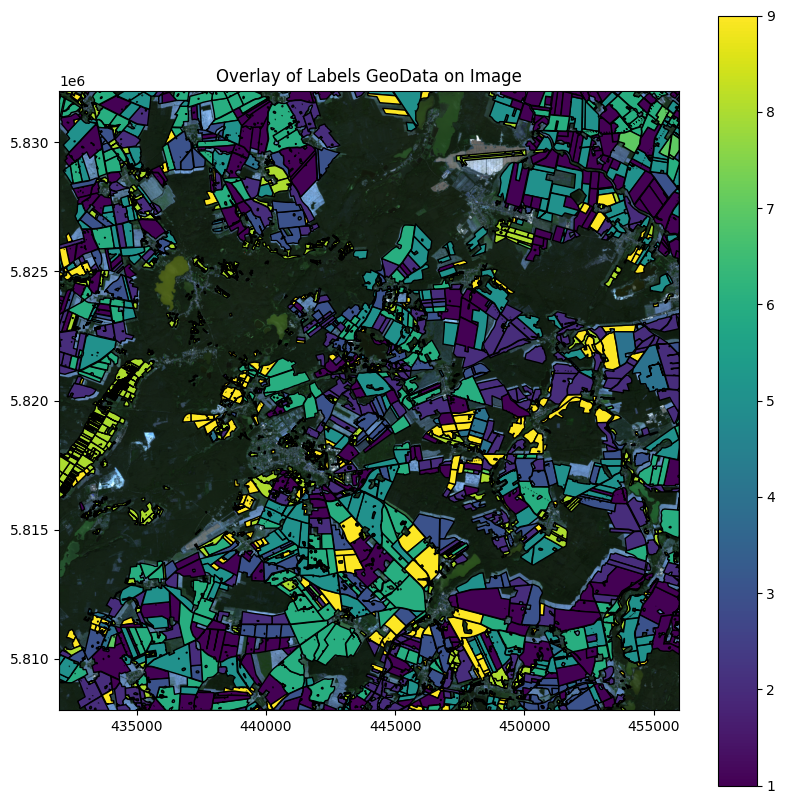

In [7]:
root_dir=os.getcwd()
train_images_dir="/media/mabso/Data/downloads/demo_segmentation/training_data"

inputs = glob.glob(train_images_dir+'/*/*', recursive=True)
#inputs = glob.glob(train_images_dirs+ '/*/*.tif', recursive=True)
train_images_dirs = sorted(inputs)
train_images_dirs =train_images_dirs[0:len(train_images_dirs)-1]
print(train_images_dirs[0:5]) # this should print something!

import tifffile as tiff
sample_image = tiff.imread('/media/mabso/Data/downloads/demo_segmentation/training_data/2018-07-31/sr.tiff') # from the traning imagery

# Adjust the brightness by scaling
brightness_factor = 0.1
adjusted_image = np.array(sample_image[:,:,(1,2,3)]) * brightness_factor

# Clip values to ensure they stay within the valid range for images
adjusted_image = np.clip(adjusted_image, 0, 255)

# Display the adjusted image
plt.imshow(adjusted_image.astype(np.uint8))  # Convert to uint8 
plt.show()

# display the adjusted image and the label masks on top of one another
xmin, ymin, xmax, ymax = labels_geo.total_bounds
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

xmin, ymin, xmax, ymax = labels_geo.total_bounds
# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Display the adjusted image as the background
ax.imshow(adjusted_image.astype(np.uint8), extent=[xmin, xmax, ymin, ymax])  # Define extent based on your image's bounds

# Overlay the labels_geo plot
labels_geo.plot(ax=ax, column='crop_id', legend=True, aspect=1, edgecolor='black')

# Set title and show the plot
ax.set_title("Overlay of Labels GeoData on Image")
plt.show()





Now this is a very big image with too much detail, and we only have approximately 60 of these, not enough for deep learning. To move forward we will do cropping and matching each indivual cropping with its labels. This get us multiple smaller examples of imagery. In addtion to statelite imagery and labels, masks are incoprated from the screen classification landscape downloaded from Sentinel Hub. The masks are utalized later in the segmentation process to remove any snow, waterbodies, clouds of heavy shadows influcening the imagery.  

In addtion to cropping, we will agument data by randomly roatating, generating blur and adjusting the brightness for each image, making the dataset more robust. 

The code below shows how to incoprote said augmentation functions alongside croppping. 

In [8]:
# rasterize and normalize imgs
def raster_read(raster_dir):
    # Read band metadata and arrays
    rgbn = rasterio.open(os.path.join(raster_dir,'sr.tiff')) #rgbn
    rgbn_src = rgbn
    target_crs = rgbn_src.crs
    print("rgbn: ", rgbn)

    # arrays
    # Read and re-scale the original 16 bit image to 8 bit.
    scale = True
    if scale:
      rgbn_norm = cv2.normalize(rgbn.read(), None, 0, 255, cv2.NORM_MINMAX)
      
      rgbn_norm_out=rasterio.open(os.path.join(raster_dir,'sr_byte_scaled.tif'), 'w', driver='Gtiff',
                                  width=rgbn_src.width, height=rgbn_src.height,
                                  count=13,
                                  crs=rgbn_src.crs,
                                  transform=rgbn_src.transform,
                                  dtype='uint8')
      #reshaped_scaled_rgbn = scaled_rgbn.reshape((-1, 13))
      rgbn_norm_out.write(rgbn_norm)
      # Write the scaled_rgbn array to the output raster
      
      rgbn_norm_out.close()
      rgbn = rasterio.open(os.path.join(raster_dir,'sr_byte_scaled.tif')) #rgbn
    else:
      rgbn = rasterio.open(os.path.join(raster_dir,'sr_byte_scaled.tif')) #rgbn
    print("Scaled to 8bit.")
    return raster_dir, rgbn, rgbn_src, target_crs


# rasterize labels
def label(geos, labels_src):
    geo_0 = gpd.read_file(geos[0])
    # check for and remove invalid geometries
    geo_0 = geo_0.loc[geo_0.is_valid]
    # reproject training data into local coordinate reference system
    geo_0 = geo_0.to_crs(crs={'init': target_crs})
    #convert the class identifier column to type integer
    geo_0['landcover_int']  = geo_0.crop_id.astype(int)
    # pair the geometries and their integer class values
    shapes_0 = ((geom,value) for geom, value in zip(geo_0.geometry, geo_0.landcover_int)) 
    if len(geos) > 1:
      geo_1 = gpd.read_file(geos[1])
      geo_1 = geo_1.loc[geo_1.is_valid]
      geo_1 = geo_1.to_crs(crs={'init': target_crs})
      geo_1['landcover_int']  = geo_1.crop_id.astype(int)
      shapes_1 = ((geom,value) for geom, value in zip(geo_1.geometry, geo_1.landcover_int)) 
    else:
      print("Only one source of vector labels.") #continue

    # get the metadata (height, width, channels, transform, CRS) to use in constructing the labeled image array
    labels_src_prf = labels_src.profile
    # construct a blank array from the metadata and burn the labels in
    labels = features.rasterize(shapes=shapes_0, out_shape=(labels_src_prf['height'], labels_src_prf['width']), fill=0, all_touched=True, transform=labels_src_prf['transform'], dtype=labels_src_prf['dtype'])
    if len(geos) > 1:
      labels = features.rasterize(shapes=shapes_1, fill=0, all_touched=True, out=labels, transform=labels_src_prf['transform'])
    else:
      print("Only one source of vector labels.") #continue

    print("Values in labeled image: ", np.unique(labels))


    return labels


# function to increase the brightness in an image, default set to 30, but can be changed randomly
def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

# function to save the rasterized images and corresponding labels, right now 11 bands are saved, but all 13 bands of sentinel 2 
# can be saved if changing the count in the "stack_out" to 13
def save_images(raster_dir, rgb_norm, stack, labels, rgb_src):

    stack_computed = True # change to True if using the stack helper function above

    if stack_computed:
      stack_t = stack.transpose(2,0,1)
    else:
      stack_t = stack

    stack_out=rasterio.open(os.path.join(raster_dir,'stack.tif'), 'w', driver='Gtiff',
                              width=rgb_src.width, height=rgb_src.height,
                              count=11,
                              crs=rgb_src.crs,
                              transform=rgb_src.transform,
                              dtype='uint8')

    stack_out.write(stack_t)
   

    labels = labels.astype(np.uint8)
    labels_out=rasterio.open(os.path.join(raster_dir,'labels.tif'), 'w', driver='Gtiff',
                              width=rgb_src.width, height=rgb_src.height,
                              count=1,
                              crs=rgb_src.crs,
                              transform=rgb_src.transform,
                              dtype='uint8')

    labels_out.write(labels, 1)

    print("written")

    return os.path.join(raster_dir,'stack.tif'), os.path.join(raster_dir,'labels.tif')

# helper function to stack all bands (change number of bands by writing more - should correspond to the counts of stack_out)
def bandstack(b1,red, green, blue,b4,b5,b6,b7,b8,b9,b11):

    stack = np.dstack((b1,red, green, blue,b4,b5,b6,b7,b8,b9,b11))

    return stack

# function to for making the augmented croped smaller titles
# outputs 3 subfolders containing cropped enteries with mataching statelite imagery, labels and masks
def tile(index_stack,labels, prefix, width, height, raster_dir, output_dir, brighten=False):
    tiles_dir = os.path.join(output_dir,'tiled/')
    img_dir = os.path.join(output_dir,'tiled/stacks_brightened/')
    mask_dir=os.path.join(output_dir,'tiled/masks/')
    label_dir = os.path.join(output_dir,'tiled/labels/')
    dirs = [tiles_dir, img_dir, label_dir,mask_dir]
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)
    
    
    def get_tiles(ds):
        # get number of rows and columns (pixels) in the entire input image
        nols, nrows = ds.meta['width'], ds.meta['height']
        # get the grid from which tiles will be made 
        offsets = product(range(0, nols, width), range(0, nrows, height))
        # get the window of the entire input image
        big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
        # tile the big window by mini-windows per grid cell
        for col_off, row_off in offsets:
            window = windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
            transform = windows.transform(window, ds.transform)
            yield window, transform

    tile_width, tile_height = width, height

    def crop(inpath, outpath, c):
        # read input image
        image = rasterio.open(inpath)
        print(image.shape)
        # get the metadata 
        meta = image.meta.copy()
        print("meta: ", meta)
        # set the number of channels to 3 or 1, depending on if its the index image or labels image
        meta['count'] = int(c)
        # set the tile output file format to PNG (saves spatial metadata unlike JPG)
        meta['driver']='GTiff'
        meta['dtype']='uint8'
        # tile the input image by the mini-windows
        i = 0
        for window, transform in get_tiles(image):
            meta['transform'] = transform
            meta['width'], meta['height'] = window.width, window.height
            outfile = os.path.join(outpath,"tile_%s_%s.tiff" % (prefix, str(i)))
            with rasterio.open(outfile, 'w', **meta) as outds:
                if brighten:
                  imw = image.read(window=window)
                  imw = imw.transpose(1,2,0)
                  imwb = change_brightness(imw, value=50)
                  imwb = imwb.transpose(2,0,1)
                  outds.write(imwb)
                else:
                  outds.write(image.read(window=window))
            i = i+1

    def process_tiles(index_flag):
        # tile the input images, when index_flag == True, we are tiling the spectral index image, 
        # when False we are tiling the labels image
        if index_flag==0:
            print("made img")
            inpath = os.path.join(raster_dir,'stack.tif')
            outpath=img_dir
            crop(inpath, outpath, 11)
        elif index_flag==1:
            print("made label")
            inpath = os.path.join(raster_dir,'labels.tif')
            outpath=label_dir
            crop(inpath, outpath, 1)
        elif index_flag==2:
             print("made mask")
             inpath = os.path.join(raster_dir,'scl.tiff')
             outpath=mask_dir
             crop(inpath, outpath, 4)

    process_tiles(index_flag=0) # tile stack
    process_tiles(index_flag=1) # tile labels
    process_tiles(index_flag=2) # tile masks
    return tiles_dir, img_dir, label_dir, mask_dir


Now before utalizing the above functions it is important to have a clean filestructure. I reccomed having labels and imagery stored in the same folder such that the above code may run smoothly without having to do any augmentations. So set your current working directory to a folder with both labels and imagery data stored in seperate folders by using the following code - note this is only to test that you have correctly stored the imagery, you may skip this if you want.

In [10]:
os.chdir('/media/mabso/Data/downloads/demo_segmentation') # change this to where you have placed the files!

root_dir=os.getcwd()

train_images_dir="/training_data" # set your imagery folder name
inputs = glob.glob(os.getcwd()+ train_images_dir+'/*', recursive=True) # test that something comes out here

train_images_dirs = sorted(inputs)
train_images_dirs =train_images_dirs[0:len(train_images_dirs)-1]
print(train_images_dirs[0:5])

['/media/mabso/Data/downloads/demo_segmentation/training_data/2018-02-01', '/media/mabso/Data/downloads/demo_segmentation/training_data/2018-02-06', '/media/mabso/Data/downloads/demo_segmentation/training_data/2018-02-08', '/media/mabso/Data/downloads/demo_segmentation/training_data/2018-02-13', '/media/mabso/Data/downloads/demo_segmentation/training_data/2018-02-16']


Time to run all the functions such that data can be rasterized, cropped and augmented. This takes a while when running the process for every image!

When the process is complete, all data will be sotred in a new folder called rasters which has 3 subfolders cotaning imagery, labels and masks. Note that here the process is only done for 1 entery for demo purposes, but you may run the full process if you want.

In [11]:
count=1
process = True
if process:
  raster_out_dir = os.path.join(root_dir,'rasters/')
  if not os.path.exists(raster_out_dir):
    os.makedirs(raster_out_dir)
    
  write_out = True #False
  if write_out == True:
    i=0
    for train_image_dir in train_images_dirs[0:1]: #remove [0:1] to get the full data
      # read the rasters and scale to 8bit
      print("reading and scaling rasters...")
      raster_dir, rgbn, rgbn_src, target_crs = raster_read(os.path.join(train_images_dir,train_image_dir))
      
      # Stack channels of interest (RGB) into one single 3 channel image
      print("Stacking channels of interest...")
      stack = bandstack(rgbn.read(1),rgbn.read(4), rgbn.read(3), rgbn.read(2),rgbn.read(5),rgbn.read(6),rgbn.read(7),
                        rgbn.read(8),rgbn.read(9),rgbn.read(10),rgbn.read(11))
      
      
      
      # Color correct the RGB image
      print("Color correcting a RGB image...")
      cc_stack = change_brightness(stack[:,:,[1,2,3]])
      
    
      # Slice the desired part of XX
      sliced_part = stack[:,:,[0,4,5,6,7,8,9,10]]

      # Stack the arrays along the last axis
      stacked_array = np.concatenate((cc_stack, sliced_part), axis=-1)
      
      print("yes")
      
      # Rasterize labels, if a different geojson file is utalized for the labels, change here!
      labels = label([os.path.join(root_dir,'training_labels/dlr_fusion_competition_germany_train_labels_33N_18E_242N/labels.geojson')], rgbn_src)
      # labels = label([os.path.join(root_dir,'test_labels/dlr_fusion_competition_germany_test_labels_33N_17E_243N/labels.geojson')], rgbn_src)
     
      # Save index stack and labels to geotiff
      print("writing scaled rasters and labels to file...")
      stack_file, labels_file = save_images(raster_dir, rgbn, stacked_array, labels, rgbn_src)
      
      prefix_0=str(train_images_dirs[i]).split("/")[7] # make sure each entery have a unique name
      
      print(prefix_0)
      
      # Tile images into 224x224 - change these numbers to something different for a different crop size
      print("tiling the indices and labels...")
      tiles_dir, img_dir, label_dir,mask_dir = tile(stack, labels, prefix_0, 224, 224, raster_dir, raster_out_dir, brighten=False)
      
      i=i+1
      
      print(i)
    
  else:
    print("Not writing to file; using data in shared drive.")

else:
  print("Using pre-processed dataset.")

reading and scaling rasters...
rgbn:  <open DatasetReader name='/media/mabso/Data/downloads/demo_segmentation/training_data/2018-02-01/sr.tiff' mode='r'>


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Scaled to 8bit.
Stacking channels of interest...
Color correcting a RGB image...
yes


/home/mabso/anaconda3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Only one source of vector labels.
Only one source of vector labels.
Values in labeled image:  [0 1 2 3 4 5 6 7 8 9]
writing scaled rasters and labels to file...
written
2018-02-01
tiling the indices and labels...
made img
(2500, 2500)
meta:  {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2500, 'height': 2500, 'count': 11, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001431110144899442, 0.0, 13.995212760670523,
       0.0, -8.728286779611665e-05, 52.636195931522316)}
made label
(2500, 2500)
meta:  {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2500, 'height': 2500, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001431110144899442, 0.0, 13.995212760670523,
       0.0, -8.728286779611665e-05, 52.636195931522316)}
made mask
(2500, 2500)
meta:  {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2500, 'height': 2500, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0001431110144899442, 0.0, 13.995212760670523,
   

Following the cropping process, not all imagery may be of the tageted 224x224 size due to the size of the orginal image. Hence, we have two options, remove the non fitting enteries or pad these. For simplicty we will just remove the non 224x224 imagery in this demo for each folder (image,label and masks), remember to set your own directory!

Finally the cleaned data is stored in seperate file lists for traning in the segmentation model later on.


In [17]:
# Iterate through the images in the folder

# mask folder removal
folder_path = '/media/mabso/Data/downloads/demo_segmentation/rasters/tiled/masks' # set your own!

for filename in os.listdir(folder_path):
    if filename.endswith('.png') or filename.endswith('.tiff'):  # Adjust file extensions as needed
        image_path = os.path.join(folder_path, filename)
       # img = Image.open(image_path)
        img=tiff.imread(image_path)
        width, height = img.shape[0],img.shape[1]
        if width != 224 or height != 224:
            print(f"Removing: {filename} - Size: {width}x{height}")
            os.remove(image_path)

# label folder removal
folder_path = '/media/mabso/Data/downloads/demo_segmentation/rasters/tiled/labels'
for filename in os.listdir(folder_path):
    if filename.endswith('.png') or filename.endswith('.tiff'):  # Adjust file extensions as needed
        image_path = os.path.join(folder_path, filename)
        img = Image.open(image_path)
        width, height = img.size
        if width != 224 or height != 224:
            print(f"Removing: {filename} - Size: {width}x{height}")
            os.remove(image_path)

# image folder removal
folder_path = '/media/mabso/Data/downloads/demo_segmentation/rasters/tiled/stacks_brightened'

for filename in os.listdir(folder_path):
    if filename.endswith('.png') or filename.endswith('.tiff'):  # Adjust file extensions as needed, defualt is tiff
        image_path = os.path.join(folder_path, filename)
        #img = Image.open(image_path)
        img=tiff.imread(image_path)
        width, height = img.shape[0],img.shape[1]
        if width != 224 or height != 224:
            print(f"Removing: {filename} - Size: {width}x{height}")
            os.remove(image_path)


# collect the files names for each folder and store these to be utalized a train and test data (split later)
# in addtion check how many images are in the folders
def get_train_test_lists(imdir, lbldir,mask_dir):
  imgs = glob.glob(os.path.join(imdir,"*.tiff"))
  #print(imgs[0:1])
  dset_list = []
  for img in imgs:
    filename_split = os.path.splitext(img) 
    filename_zero, fileext = filename_split 
    basename = os.path.basename(filename_zero) 
    dset_list.append(basename)

  x_filenames = []
  y_filenames = []
  mask_filenames=[]
  for img_id in dset_list:
    x_filenames.append(os.path.join(imdir, "{}.tiff".format(img_id)))
    y_filenames.append(os.path.join(lbldir, "{}.tiff".format(img_id)))
    mask_filenames.append(os.path.join(mask_dir, "{}.tiff".format(img_id)))

  print("number of images: ", len(dset_list))
  return dset_list, x_filenames, y_filenames, mask_filenames

label_dir="/media/mabso/Data/downloads/demo_segmentation/rasters/tiled/labels"
img_dir="/media/mabso/Data/downloads/demo_segmentation/rasters/tiled/stacks_brightened"
mask_dir="/media/mabso/Data/downloads/demo_segmentation/rasters/tiled/masks"

train_list, x_train_filenames, y_train_filenames, mask_train_filenames = get_train_test_lists(img_dir, label_dir,mask_dir)



number of images:  121


Lets see what came out of the processing of data 

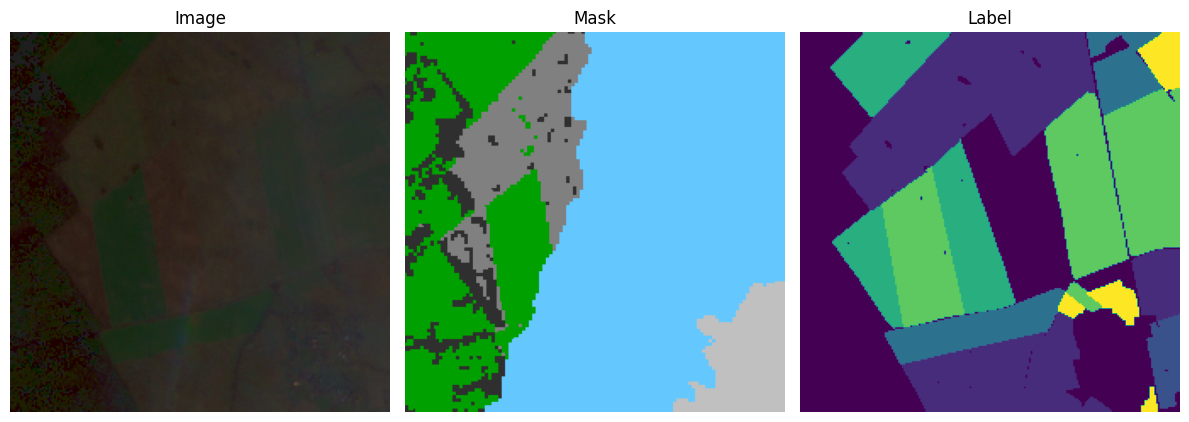

In [21]:
# Read the image and mask
img_num=1

image = tiff.imread(x_train_filenames[img_num])[:, :, 0:3]  # RGB image
mask = tiff.imread(mask_train_filenames[img_num])[:, :]  # Mask
label = tiff.imread(y_train_filenames[img_num])[:, :]  # Label

# Create subplots
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Display the image
ax[0].imshow(image)
ax[0].set_title("Image")
ax[0].axis("off")

# Display the mask
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Mask")
ax[1].axis("off")

# Display the mask
ax[2].imshow(label)
ax[2].set_title("Label")
ax[2].axis("off")

# Show the plot
plt.tight_layout()
plt.show()

The processing of data is almost done now. However, one more thing needs to be accounted for which is the number of background tiles. In our case the image is not fully labeled and therefore instance with "blank" labels will occur. To ensure that we keep a balance between blank labels and labels we figure out how many of the croped images cotain blank labels and removes a portion of these.

In [23]:
# find number of background tiles

skip = False

if not skip:
  background_list_train = []
  for i in train_list: 
      # read in each labeled images
      # print(os.path.join(label_dir,"{}.png".format(i))) 
      img = np.array(Image.open(os.path.join(label_dir,"{}.tiff".format(i))))  
      # check if no values in image are greater than zero (background value)
      if img.max()==0:
          background_list_train.append(i)

  print("Number of background images: ", len(background_list_train))

  with open(os.path.join(root_dir,'background_list_train.txt'), 'w') as f:
    for item in background_list_train:
        f.write("%s\n" % item)

else:
  background_list_train = [line.strip() for line in open("background_list_train.txt", 'r')]
  print("Number of background images: ", len(background_list_train))

Number of background images:  1


In [24]:
# remove 90% of background tiles
root_dir=os.getcwd()
background_removal = len(background_list_train) * 0.9
train_list_clean = [y for y in train_list if y not in background_list_train[0:int(background_removal)]]

x_train_filenames = []
y_train_filenames = []
mask_train_filenames = []

for i, img_id in zip(range(len(train_list_clean)), train_list_clean):
  pass 
  x_train_filenames.append(os.path.join(img_dir, "{}.tiff".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}.tiff".format(img_id)))
  mask_train_filenames.append(os.path.join(mask_dir, "{}.tiff".format(img_id)))
  #print(i)
print("Number of background tiles: ", background_removal)
print("Remaining number of tiles after 90% background removal: ", len(train_list_clean))

Number of background tiles:  0.9
Remaining number of tiles after 90% background removal:  121


With the background tiles brought down (in this case we only had 1, but for the full dataset there is alot more!). The next step is to split the data into traning and testing data for segmentation model training. we have plenty of data with the full set so we split into traning, validation and test set. Finally we check if the splits are blanced in between label classes to ensure representation is adequte.

In [26]:
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames,mask_train_filenames, mask_val_filenames = train_test_split(x_train_filenames, y_train_filenames,mask_train_filenames, test_size=0.3, random_state=42)
x_val_filenames, x_test_filenames, y_val_filenames, y_test_filenames,mask_val_filenames, mask_test_filenames = train_test_split(x_val_filenames, y_val_filenames,mask_val_filenames, test_size=0.33, random_state=42)

num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))
print("Number of test examples: {}".format(num_test_examples))


Number of training examples: 58
Number of validation examples: 17
Number of test examples: 9


In [27]:
vals_train = []
vals_val = []
vals_test = []

def get_vals_in_partition(partition_list, x_filenames, y_filenames):
  for x,y,i in zip(x_filenames, y_filenames, range(len(y_filenames))):
      pass 
      try:
        img = np.array(Image.open(y)) 
        vals = np.unique(img)
        partition_list.append(vals)
      except:
        continue

def flatten(partition_list):
    return [item for sublist in partition_list for item in sublist]

get_vals_in_partition(vals_train, x_train_filenames, y_train_filenames)
get_vals_in_partition(vals_val, x_val_filenames, y_val_filenames)
get_vals_in_partition(vals_test, x_test_filenames, y_test_filenames)

print("Values in training partition: ", set(flatten(vals_train)))
print("Values in validation partition: ", set(flatten(vals_val)))
print("Values in test partition: ", set(flatten(vals_test)))


Values in training partition:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Values in validation partition:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Values in test partition:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


Congratulations, you have made it to the end of this part of the demo. If you want to know how to train the model move on to the next part of the tourtrial. see you in the next notebook.